In [22]:
import torch, torch.nn as nn, torch.nn.functional as F

In [36]:
torch.randn(2,10)[...,None].shape


torch.Size([2, 10, 1])

In [42]:
recon_loss_fn = lambda *args, **kwargs: torch.tensor(0., device=x.device)
recon_loss_fn('d', d=2)

tensor(0.)

In [24]:
class Halfer(nn.Module): # uses conv instead of avg_pool1d
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim*2, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.ff = nn.Linear(dim*2, dim)

    def forward(self, x, length):
        if x.shape[1] % 2 == 1:
            x = torch.cat([x, torch.zeros_like(x[:,0:1,:])], dim=1)
            length += 1
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = (length + 1).div(2).floor().long()
        return x, length

class InverseHalfer(nn.Module): # opposite of Halfer
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim//2, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.ff = nn.Linear(dim//2, dim)

    def forward(self, x, length):
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = length.mul(2)
        return x, length

class HalferBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.halfer = Halfer(dim)
        self.inverse_halfer = InverseHalfer(dim)
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, x, length, mask=None):
        halved_x, halved_length = self.halfer(x, length)
        loss = torch.tensor(0., device=x.device)
        if self.training:
            restored_x, restored_length = self.inverse_halfer(x, halved_length)
            restored_x = restored_x[:, :x.shape[1], :] # trim to original length
            loss = self.loss(restored_x, x)
            if mask is not None: # mask out padding
                loss.masked_fill_(mask, 0)
            loss = loss.mean()
        return halved_x, halved_length, loss


In [29]:
halfer = Halfer(256)
inv_halfer = InverseHalfer(256)
x = torch.randn(2, 100, 256)
length = torch.tensor([100, 65])
x, length = halfer(x, length)
print(x.shape, length)
x, length = inv_halfer(x, length)
print(x.shape, length)

torch.Size([2, 50, 256]) tensor([50, 33])
torch.Size([2, 100, 256]) tensor([100,  66])


In [34]:
a = torch.randn(3, 8, 32)
b = torch.randn(3, 8, 32)
mseloss = torch.nn.MSELoss(reduction='none')
loss = mseloss(a, b)
loss = loss.mean()
print(loss)

tensor(1.9711)


In [51]:
import matplotlib.pyplot as plt
import numpy as  np

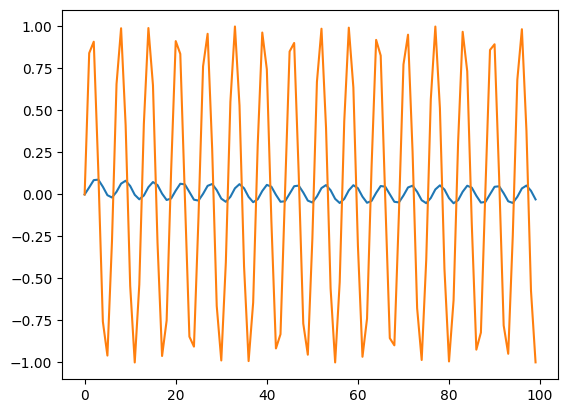

In [61]:
# task plot EMA with decay of 0.99 for 1000 steps of a sin wave
ema_update = np.sin(np.arange(1000))
ema = ema_update[0]
decay = 0.95
ema_list = []
for i in range(100):
    ema = ema * decay + ema_update[i] * (1 - decay)
    ema_list.append(ema)    
plt.plot(ema_list)
plt.plot(ema_update[:100])

In [64]:
import torch_optimizer as optim

# model = ...
optimizer = optim.Shampoo(
    lr=1e-1,
    momentum=0.0,
    weight_decay=0.0,
    epsilon=1e-4,
    update_freq=1,
)

TypeError: __init__() missing 1 required positional argument: 'params'

In [1]:
import argparse
import pickle as pkl
from Levenshtein import distance
from speachy.rescoring.tools import ( sort_hypothesis_by_recording, order_recordings_by_start_time, )
import numpy as np
from functools import reduce
import torch
import os
import traceback
from speachy.utils.misc import ( add_common_args, get_parameters, load_pkl )

from speachy.utils.general import (
    load_config,
    load_checkpoint,
    load_tokenizer,
    save_checkpoint,
    save_schedular_data,
    write_to_log,
    draw_text,
)

from speachy.lm.tools.train import (
    loss_ce,
    batch_to_device,
    token_lens_to_mask,
    add_bos,
    add_eos,
    mark_padding
)

from speachy.utils.general import load_checkpoint
from speachy.lm.tools.loading import autoload
from speachy.utils.helpers import  exists, isfalse, istrue
from speachy.utils.general.training_loop import optimizer, update_schedular
from contextlib import nullcontext
from tqdm import tqdm
import wandb
from torch.cuda.amp import GradScaler   
from torch_ema import ExponentialMovingAverage

[NeMo W 2023-03-17 18:30:46 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-03-17 18:30:46 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [3]:
device, config = torch.device('cpu'), load_config('./experiment_configs/lm/uniformer_test.yaml')
tokenizer_path = os.path.join(config['model']['tokenizer']['dir'], 'tokenizer.model')
tokenizer = load_tokenizer(model_path=tokenizer_path)
model = autoload(config=config, tokenizer=tokenizer)
class argsclass:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
epoch_prev, val_loss = load_checkpoint(args=argsclass(**{'checkpoint':'./checkpoints/unitformer_test/checkpoint_7_id_46.pt'}), model=model, force_cpu=True)

29
186
471
841
./checkpoints/unitformer_test/checkpoint_7_id_46.pt
odict_keys(['layers.positional_bias.mlp.0.0.weight', 'layers.positional_bias.mlp.0.0.bias', 'layers.positional_bias.mlp.1.0.weight', 'layers.positional_bias.mlp.1.0.bias', 'layers.positional_bias.mlp.2.weight', 'layers.positional_bias.mlp.2.bias', 'layers.layers.0.0.norm.weight', 'layers.layers.0.0.norm.bias', 'layers.layers.0.0.fn.q_proj.weight', 'layers.layers.0.0.fn.kv_proj.weight', 'layers.layers.0.0.fn.out_proj.weight', 'layers.layers.0.1.norm.weight', 'layers.layers.0.1.norm.bias', 'layers.layers.0.1.fn.q_proj.weight', 'layers.layers.0.1.fn.kv_proj.weight', 'layers.layers.0.1.fn.out_proj.weight', 'layers.layers.0.2.norm.weight', 'layers.layers.0.2.norm.bias', 'layers.layers.0.2.fn.0.proj.weight', 'layers.layers.0.2.fn.0.proj.bias', 'layers.layers.0.2.fn.2.weight', 'layers.layers.0.2.fn.2.bias', 'layers.layers.0.3.norm.weight', 'layers.layers.0.3.norm.bias', 'layers.layers.0.3.fn.0.proj.weight', 'layers.layers.0.3.

In [4]:
import matplotlib.pyplot as plt

In [10]:
labels = tokenizer.text_to_ids('New Deep Learning Optimizer, Ranger: Synergistic combination of RAdam'.lower())
labels = torch.tensor(labels, device=device)[None]
labels = add_bos(labels, 0)
lengths = torch.tensor([len(labels[0])], device=device)
model.eval()
out = model(labels, lengths)

In [74]:
out['targets']

[tensor([[ 0,  1,  7,  2, 17,  1, 12,  2,  2, 20,  1, 11,  2,  4, 10,  7,  6,  7,
          18,  1,  5, 20,  3,  6, 16,  6, 27,  2, 10,  0,  1, 10,  4,  7, 18,  2,
          10,  0,  1,  8, 15,  7,  2, 10, 18,  6,  8,  3,  6, 14,  1, 14,  5, 16,
          21,  6,  7,  4,  3,  6,  5,  7,  1,  5, 19,  1, 10,  4, 12,  4, 16]]),
 tensor([[  1,  87,  83,  84, 112, 121, 112,  58,  79, 164,  22,  55,  55,  84,
            0,  93, 167,  94,   0, 173, 167, 166,  55, 135, 132,  21, 179,  55,
           23,  55,  38,  93, 133,  58,  23,  22]]),
 tensor([[226, 425, 239, 239, 239, 239, 239, 239, 239, 129, 129, 239, 239, 239,
          239, 239, 239, 239]]),
 tensor([[336, 336, 336, 336, 336, 336, 336, 336, 336]])]

In [72]:
tohighlight[0][5]

1

In [50]:
embedding[tohighlight[0][5], 0]

-10.652408

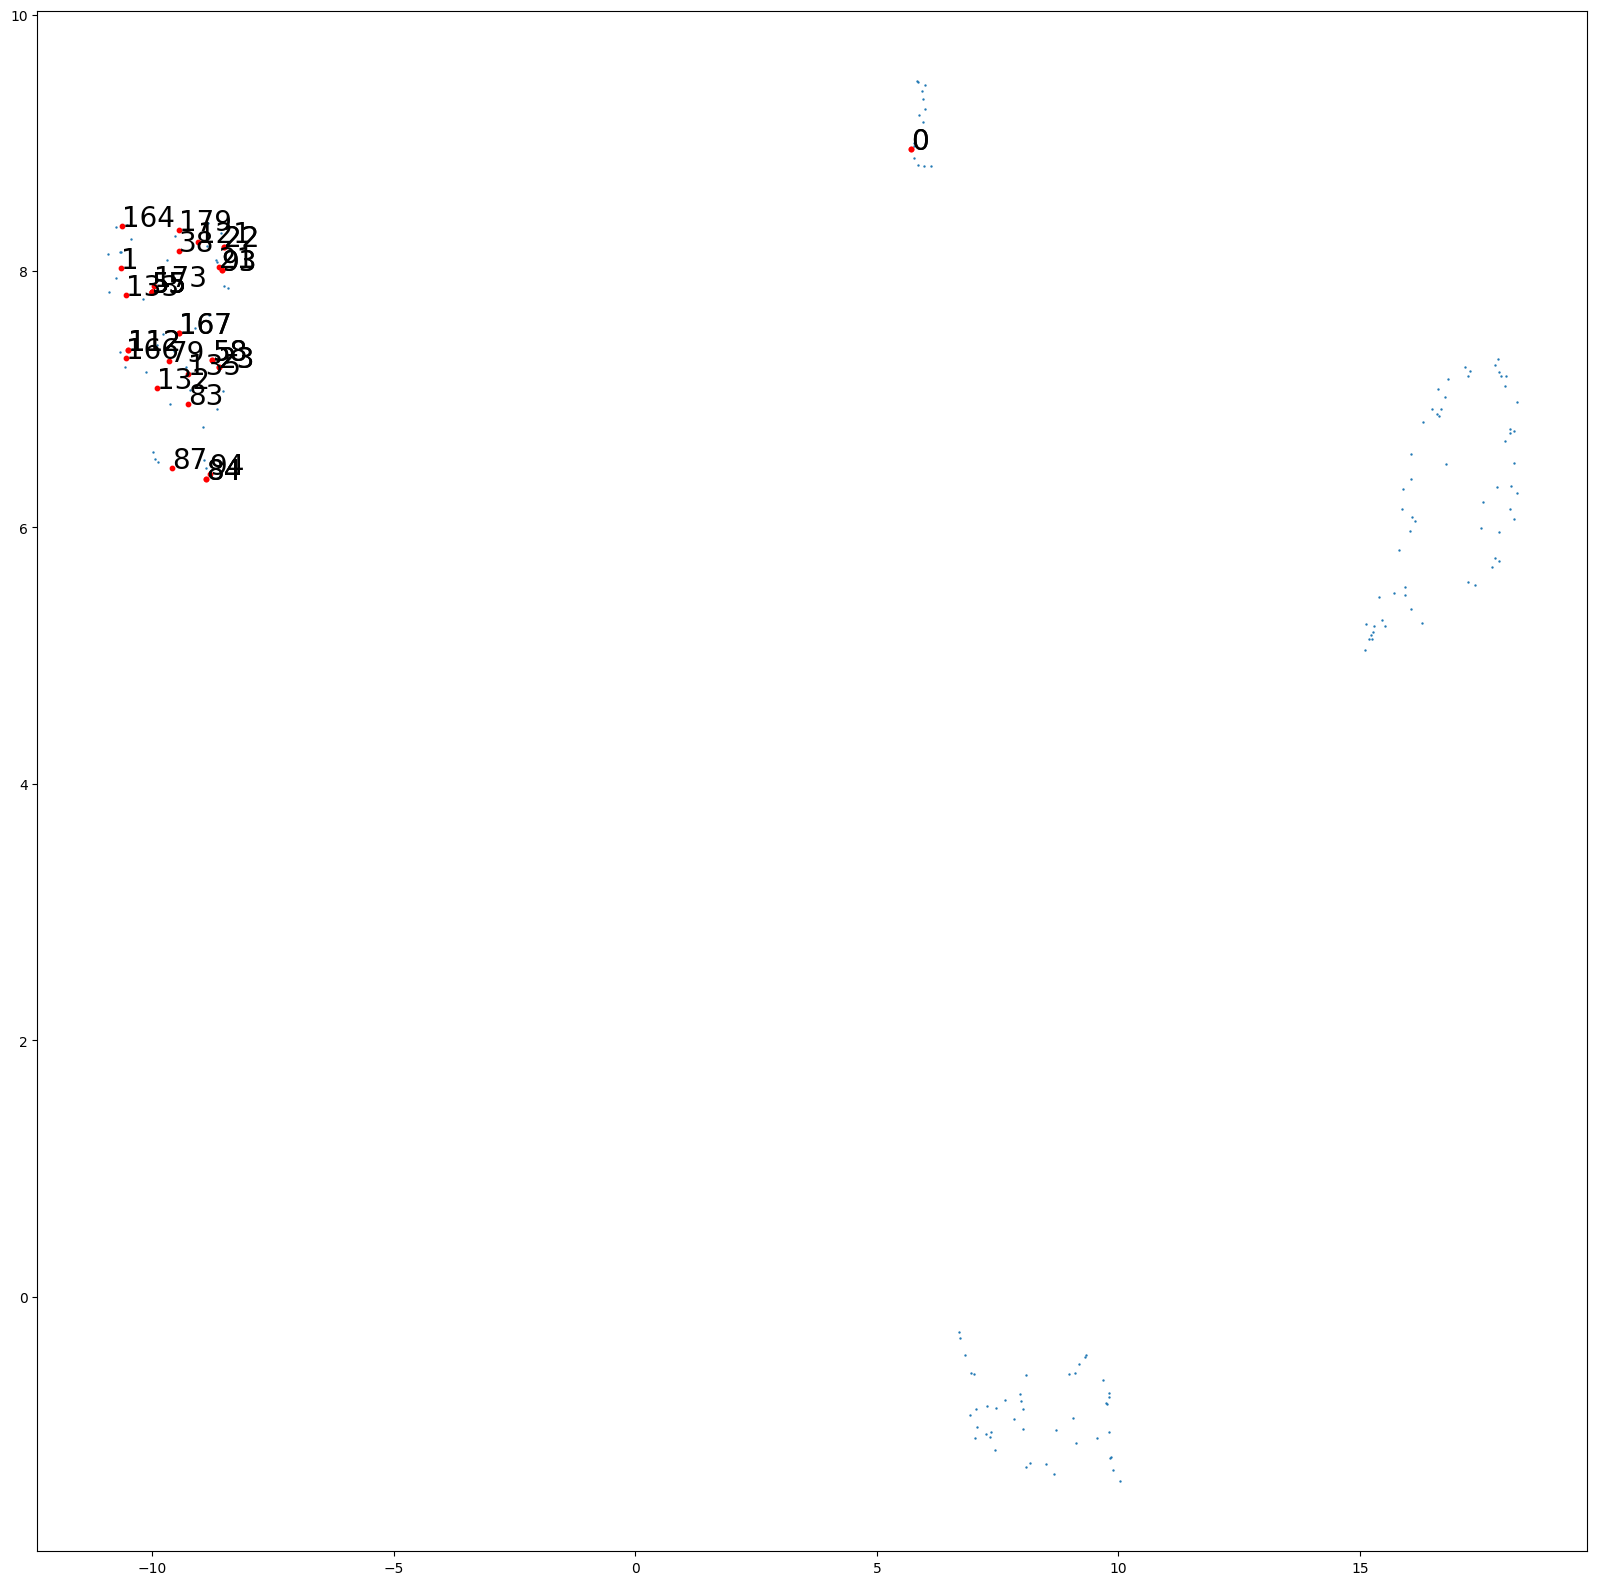

In [77]:
tohighlight = out['targets'][1].tolist()
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.5)
for i in range(len(tohighlight[0])):
    #plt.scatter(embedding[tohighlight[i], 0], embedding[tohighlight[i], 1], s=10.0, c='r')
    # same as in comment except add index as text/label
    plt.scatter(embedding[tohighlight[0][i], 0], embedding[tohighlight[0][i], 1], s=10.0, c='r')
    plt.text(embedding[tohighlight[0][i], 0], embedding[tohighlight[0][i], 1], str(tohighlight[0][i]), fontsize=20)

    
# enlarge the plot
plt.rcParams['figure.figsize'] = [5, 5]

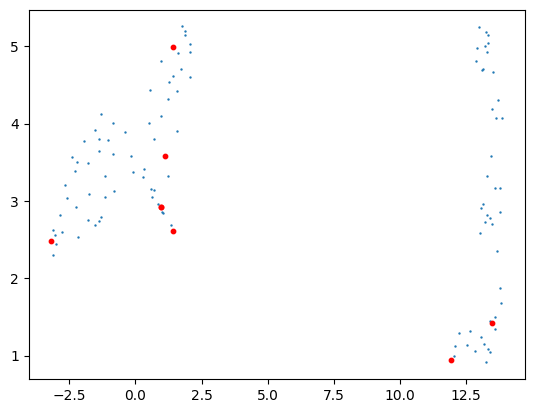

In [23]:
tohighlight = out['targets'][1].tolist()
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.5)
for i in range(len(tohighlight)):
    plt.scatter(embedding[tohighlight[i], 0], embedding[tohighlight[i], 1], s=10.0, c='r')


In [12]:
model.layers.layers[0][-1].codebook.shape

torch.Size([186, 256])

In [155]:
from math import ceil

In [165]:
a = lambda l: min(10000, ceil((28 * l)**1.5)) + 29
[a(i) for i in range(0, 5)]

[29, 178, 449, 799, 1215]

In [ ]:
num_l = len(model.layers.layers)
for lth in range(0, num_l-1):
    print(model.layers.layers[lth][-1].codebook)

In [19]:
data = model.layers.layers[0][-1].codebook

In [20]:
data.shape

torch.Size([186, 256])

In [129]:
# loss function that maximizes the distance between the codebook vectors 
def loss(codebook):
    n = codebook.size(0)
    sim = torch.matmul(codebook, codebook.t())
    sim = torch.nn.functional.log_softmax(sim, dim=1)
    loss = -torch.sum(torch.diag(sim))
    loss /= n
    return loss

In [130]:
max_diff_loss(data)

tensor(4.0598)

In [117]:
torch.log(torch.tensor(0.09))

tensor(-2.4079)

In [16]:
import umap

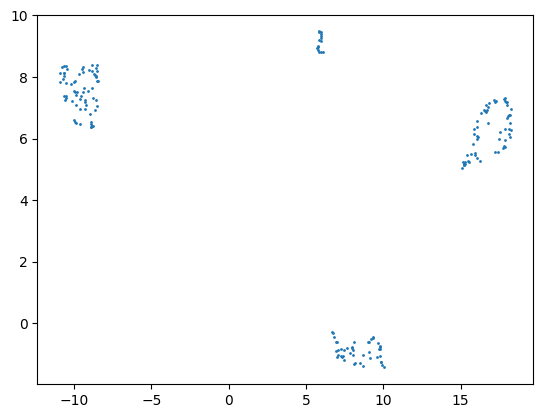

In [21]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data.detach().cpu().numpy())
plt.scatter(embedding[:, 0], embedding[:, 1], s=1.0)

In [42]:
import torch
from vector_quantize_pytorch import VectorQuantize

vq = VectorQuantize(
    dim = 256,
    codebook_dim = 32,                  # a number of papers have shown smaller codebook dimension to be acceptable
    heads = 4,                          # number of heads to vector quantize, codebook shared across all heads
    separate_codebook_per_head = True,  # whether to have a separate codebook per head. False would mean 1 shared codebook
    codebook_size = 29,
)

img_fmap = torch.randn(2, 120, 256)
quantized, indices, loss = vq(img_fmap)



In [59]:
indices

tensor([[[ 4, 26,  7,  8],
         [ 4,  2, 16, 18],
         [ 2, 24, 14, 16],
         [ 1, 28,  5, 16],
         [ 0, 26,  7, 15],
         [16,  1, 16, 19],
         [14, 14, 20,  2],
         [ 5, 21,  8,  0],
         [12, 15, 20,  1],
         [23, 25, 26, 21],
         [22, 20,  5, 16],
         [16,  1, 24, 19],
         [11, 19, 28, 26],
         [17, 27,  6, 13],
         [ 6,  4, 26, 18],
         [18, 24, 15, 22],
         [19,  6,  9, 15],
         [ 3, 25, 14, 24],
         [10, 25, 10,  5],
         [23, 25, 21,  4],
         [27,  1, 13,  8],
         [17, 14, 11, 11],
         [14, 19, 28, 10],
         [22, 14, 12, 21],
         [11, 15,  1,  4],
         [17,  6, 13, 18],
         [24, 22, 26, 26],
         [ 4, 26, 19,  0],
         [ 8,  1, 11, 18],
         [ 4,  2, 16, 14],
         [17,  7, 18, 14],
         [12,  0,  0, 11],
         [19,  9, 28, 27],
         [17, 14, 14, 11],
         [ 6, 21, 17, 16],
         [23,  0,  6, 24],
         [ 6, 13, 12, 26],
 

In [261]:
import torch, torch.nn as nn, torch.nn.functional as F
from speachy.lm.tools.train import add_eos, token_lens_to_mask, mark_padding
import numpy as np
from einops import rearrange, repeat
from torch import einsum
from torch.utils.checkpoint import checkpoint # # gradient/activation checkpointing
from functools import partial
import string
from math import ceil
from vector_quantize_pytorch import RandomProjectionQuantizer, VectorQuantize
from typing import Optional, Tuple, List, Dict, Union, Callable

def exists(val):
    return val is not None

# token shifting
# lucidrains implementation: https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py
# BlinkDL idea from RWKV-LM https://github.com/BlinkDL/RWKV-LM
def shift(t, amount, mask = None):
    if amount == 0:
        return t
    else:
        amount = min(amount, t.shape[1])

    if exists(mask):
        t = t.masked_fill(~mask[..., None], 0.)

    return F.pad(t, (0, 0, amount, -amount), value = 0.)

class ShiftTokens(nn.Module):
    '''from Phil Wang's x-transformers library'''
    def __init__(self, shifts, fn):
        super().__init__()
        self.fn = fn
        self.shifts = tuple(shifts)

    def forward(self, x, **kwargs):
        mask = kwargs.get('mask', None)
        shifts = self.shifts
        segments = len(shifts)
        feats_per_shift = x.shape[-1] // segments
        splitted = x.split(feats_per_shift, dim = -1)
        segments_to_shift, rest = splitted[:segments], splitted[segments:]
        segments_to_shift = list(map(lambda args: shift(*args, mask = mask), zip(segments_to_shift, shifts)))
        x = torch.cat((*segments_to_shift, *rest), dim = -1)
        return self.fn(x, **kwargs)


class DynamicPositionBias(nn.Module):
    '''Adapted from Phil Wang's x-transformers library'''
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False, activation=nn.ReLU):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            activation()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                activation()
            ))

        self.mlp.append(nn.Linear(dim, heads))


    def forward(self, pos, indices, device, dtype):
        pos = pos.to(device=device, dtype=dtype)
        
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos) 
      
        bias = pos[indices]
        #print(bias.shape)
        bias = rearrange(bias, 'b i j h -> b h i j')
        return bias

class ScaledSinuEmbedding(nn.Module):
    '''taken From Phil Wang's x-transformers library'''
    def __init__(self, dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1,))
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        n, device = x.shape[1], x.device
        t = torch.arange(n, device = device).type_as(self.inv_freq)
        sinu = einsum('i , j -> i j', t, self.inv_freq)
        emb = torch.cat((sinu.sin(), sinu.cos()), dim = -1)
        return emb * self.scale

class ReLUSquared(nn.Module):
    def forward(self, x):
        return torch.pow(F.relu(x), 2)

def l2norm(t, groups = 1, dim = -1):
    if groups == 1:
        return F.normalize(t, p = 2, dim = dim)
    t = rearrange(t, '... (g d) -> ... g d', g = groups)
    t = F.normalize(t, p = 2, dim = dim)
    return rearrange(t, '... g d -> ... (g d)')



class Attention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.1,
        bias=False,
        return_attention=False,
        causal=False,
        activation='softmax',
        **kwargs
    ):
        super().__init__()
        assert activation in ['relusq', 'softmax']
        self.shared_kv = kwargs.get('shared_kv', False)
        
        self.talking_heads = kwargs.get('talking_heads', 'none') # 'none', 'pre', 'both', 'post' 

        self.n_feats, self.head_dim, self.n_heads = n_feats, head_dim, n_heads
        self.dropout = nn.Dropout(dropout)
        self.bias = bias
        self.return_attention = return_attention
        self.causal = causal

        if self.talking_heads == 'pre' or self.talking_heads == 'both':
            self._head_proj = nn.Conv2d(n_heads, n_heads, (1, 1))
        if self.talking_heads == 'post' or self.talking_heads == 'both':
            self._head_proj_post = nn.Conv2d(n_heads, n_heads, (1, 1))
            

        self.activation = ReLUSquared() if activation == 'relusq' else nn.Softmax(dim=-1)

        if not self.shared_kv:
            self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
            self.qkv = lambda x: rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=n_heads, d=head_dim)
        else:
            self.q_proj, self.kv_proj = [nn.Linear(n_feats, el, bias=bias) for el in [n_heads * head_dim, 2 * head_dim]]
            map_q, map_kv = lambda q: rearrange(q, 'b n (h d) -> b h n d', h=n_heads), lambda kv: rearrange(kv, 'b n (kv d) -> kv b () n d', kv=2, d=head_dim)
            self.qkv = lambda x: (map_q(self.q_proj(x)), *map_kv(self.kv_proj(x)))

        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)
    
    def head_proj(self, dots, mode='pre'):
        if mode == 'pre' and (self.talking_heads == 'pre' or self.talking_heads == 'both'):
            dots = self._head_proj(dots)
        if mode == 'post' and (self.talking_heads == 'post' or self.talking_heads == 'both'):
            dots = self._head_proj_post(dots)
        return dots      
  

    def attend(self, query, key, value, attn_mask, pos_bias):        
        dots = einsum('bhid,bhjd->bhij', query, key) * self.head_dim ** -0.5
        dots = self.head_proj(dots, mode='pre')

        dots += pos_bias

        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)

        attn = self.activation(dots)
        attn = self.head_proj(attn, mode='post')
     
        attn = self.dropout(attn)
        return einsum("bhij,bhjd->bhid", attn, value)

    @staticmethod
    def attach_cache(kv, cache, cache_indices):
        kv = torch.stack(kv, dim=0)
        if cache is None:
            return kv
        zero_vector = torch.zeros_like(kv[:, :, :, :1, :])
        kv_w_cache = torch.cat([cache, kv, zero_vector], dim=-2)
        kv_w_cache = torch.gather(kv_w_cache, dim=-2, index=cache_indices) # we do this to remove unnecessary padding
        return kv_w_cache

    def forward(self, x, pos_bias, mask, cache=None, cache_indices=None):
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim
    
        q, k, v  = self.qkv(x)
        kv = self.attach_cache([k, v], cache, cache_indices)
        k, v = kv

        out = self.attend(q, k, v, mask, pos_bias)

        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.out_proj(out)
        return out, kv

class PreNorm(nn.Module):
    def __init__(self, dim, fn, elementwise_affine=True):
        super().__init__()
        self.norm = nn.LayerNorm(dim, elementwise_affine=elementwise_affine)
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(self.norm(x), *args, **kwargs)


class GLU(nn.Module):
    def __init__(self, dim_in, dim_out, activation):
        super().__init__()
        self.act = activation
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim = -1)
        return x * self.act(gate)


class Halfer(nn.Module): # uses conv instead of avg_pool1d
    def __init__(self, dim, exp_f=2):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim*exp_f, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.empty_vec = nn.Parameter(torch.zeros(1,1,dim))
        self.ff = nn.Linear(dim*exp_f, dim)

    def forward(self, x, length):
        if x.shape[1] % 2 == 1:
            x = torch.cat([x, self.empty_vec.expand(x.shape[0],1,-1)], dim=1)
            length += 1
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = (length + 1).div(2).floor().long()
        return x, length

class InverseHalfer(nn.Module): # opposite of Halfer
    def __init__(self, dim, exp_f=2):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim*exp_f, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.ff = nn.Linear(dim*exp_f, dim)

    def forward(self, x, length):
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = length.mul(2)
        return x, length

class HalferBlock(nn.Module):
    def __init__(self, dim, exp_f=2):
        super().__init__()
        self.halfer = PreNorm(dim=dim, fn=Halfer(dim, exp_f=exp_f))
        self.inverse_halfer = PreNorm(dim=dim, fn=InverseHalfer(dim, exp_f=exp_f))
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, x, length, mask=None):
        halved_x, halved_length = self.halfer(x, length)
        def recon_loss_fn(quantized_x):
            restored_x, _ = self.inverse_halfer(quantized_x, halved_length)
            restored_x = restored_x[:, :x.shape[1], :] # trim to original length
            loss = torch.tensor([0.], device=x.device)
            if self.training:
                loss = self.loss(restored_x, x)
                if mask is not None: # mask out padding
                    loss.masked_fill_(mask[..., None], 0.)
                loss = loss.mean()
            return loss, restored_x
        return halved_x, halved_length, recon_loss_fn



class PredictionLayer(nn.Module):
    def __init__(self, dim, n_classes):
        super().__init__()
        self.proj = PreNorm(dim, nn.Linear(dim, n_classes))
    def forward(self, x):
        return self.proj(x)

class NextTokenPredictor(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.gamma = nn.Parameter(torch.randn(1,n_classes))
        self.beta = nn.Parameter(torch.randn(1,n_classes))
        nn.init.uniform_(self.gamma, 0.5, 1.5)
        nn.init.uniform_(self.beta, -0.1, 0.1)

    def forward(self, x, length):
        # get the last token in x
        last_logits = x[torch.arange(x.shape[0]), length-1] 
        last_logits = last_logits * self.gamma + self.beta
        return last_logits[:,None,:]



class transformer(nn.Module):
    def __init__(
            self, 
            dim, 
            depth, 
            heads, 
            dim_head, 
            causal=True,
            base_vocab_size=29,
            dropout = 0.1,
            **kwargs
        ):
        super().__init__()
    

        ff_mult = kwargs.get('ff_mult', 4)
        self.checkpoint_every_n = kwargs.get('checkpoint_every_n', 0)
        self.base_vocab = base_vocab_size
        self.max_vocab = kwargs.get('max_vocab', 10000)
        commitment_weight = kwargs.get('commitment_weight', 1.0)

        self.embedding = nn.Embedding(base_vocab_size, dim)

        self.causal = causal

        self.depth = depth
        self.positional_bias = DynamicPositionBias(
            dim = dim // 4,
            heads = heads,
            depth = 2,
            log_distance = False,
            norm = False
        )
        self.halfer = HalferBlock(dim, exp_f=4)

        self.vocab_fn = lambda l: min(self.max_vocab, ceil(((self.base_vocab * l)**1.5))) + self.base_vocab
        self.layers = nn.ModuleList([])
        for lth in range(depth):
            print(f'v: {self.vocab_fn(lth)}')
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(
                    dim, 
                    n_heads=heads, 
                    head_dim=dim_head, 
                    causal=causal,
                    dropout=dropout,
                    **kwargs
                )),
                PreNorm(dim, Attention(
                    dim, 
                    n_heads=heads, 
                    head_dim=dim_head, 
                    causal=causal,
                    dropout=dropout,
                    **kwargs
                )),
                PreNorm(dim, self.ff(dim, mult=ff_mult)),
                PreNorm(dim, self.ff(dim, mult=ff_mult)),
                PredictionLayer(dim, self.vocab_fn(0)) if lth==0 else PredictionLayer(dim, dim),
                NextTokenPredictor(n_classes=self.vocab_fn(lth)),
                PreNorm(dim, VectorQuantize(
                    dim = dim,
                    codebook_dim = 64,
                    codebook_size = self.vocab_fn(lth + 1),
                    commitment_weight=commitment_weight,
                    kmeans_init = True,
                    orthogonal_reg_weight = 10.0,
                    orthogonal_reg_max_codes = 128,
                    use_cosine_sim = True,
                    decay=0.9,
                    threshold_ema_dead_code=0.05,
                )) if lth < depth - 1 else None # no vector quantization in the last layer
            ]))

    @staticmethod
    def ff(dim, mult=4, dropout=0.1):
        return nn.Sequential(
            GLU(dim, dim * mult, nn.SiLU()),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    @staticmethod
    def create_custom_forward(module):
        def custom_forward(*args, **kwargs):
            return module(*args, **kwargs)
        return custom_forward

    def checkpoint(self, layer, module, *args, **kwargs):
        condition = self.training and self.checkpoint_every_n != 0 and layer < self.depth - 1 and layer % self.checkpoint_every_n == 0
        return checkpoint(self.create_custom_forward(module), *args, **kwargs) if condition else module(*args, **kwargs)

    @staticmethod
    def get_cache(cache):
        if cache is None:
            return None
        return cache['cache'][0]

    @staticmethod
    def get_cache_indices(x_lens, cache_lens, cache_kv, x):  
        # used later w/ gather to remove padding when cache is concatenated with current input to remove padding
        max_new_len = (x_lens + cache_lens).max()
        # cache kv =  LAYERS, KEYS+VALUES (2), BATCH, HEADS, N, DIM
        B, H, N, D = x.shape[0], cache_kv.shape[-3], (x.shape[1] + cache_kv.shape[-2]), cache_kv.shape[-1]
        indices = []
        for i in range(B): # stinky for loop to sort out indices for gather 
            cache_indices = torch.arange(cache_lens[i], device='cpu')
            total_length = cache_lens[i] + x_lens[i] 
            diff_from_max_len = max_new_len - total_length
            x_indices = torch.arange(x_lens[i]+diff_from_max_len, device='cpu') + cache_kv.shape[-2]
            if diff_from_max_len > 0:
                x_indices[-diff_from_max_len:] = N  # last index will be used for padding
            new_indices = torch.cat([cache_indices, x_indices])
            indices.append(new_indices)

        indices = torch.stack(indices, dim=0)
        
        indices = rearrange(indices, 'b n -> () b () n ()').expand(2, B, H,-1, D) # 2 for key and value
        return indices.to(x.device)

    def create_masks_and_positions(self, x, length, cache): 
        x_len = length if length is not None else torch.tensor(x.shape[-2]).expand(x.shape[0])
        cache_len = cache['cache_lengths'] if exists(cache) else 0

        total_len = x_len + cache_len
        kv_mask = torch.arange(total_len.max(), device=x.device).expand(len(total_len), -1) >= total_len.unsqueeze(-1)
        q_mask = torch.arange(x_len.max(), device=x.device).expand(len(x_len), -1) >= x_len.unsqueeze(-1)
        attn_mask = ~(rearrange(~q_mask, "b n -> b () n ()") * rearrange(~kv_mask, "b n -> b () () n"))
        ##
        ##
        causal_mask = repeat(torch.arange(total_len.max(), device=x.device), 'i -> b r i', b=len(total_len), r=x_len.max())
        cache_offset = cache_len[:,None,None] if exists(cache) else cache_len
        diagonal_offset = torch.arange(x_len.max(), device=x.device)[None,:,None]
        ##
        ## positional stuff ##
        positional_grid = (causal_mask - cache_offset - diagonal_offset) * -1
        pos = torch.arange(positional_grid.min(), positional_grid.max()+1, device=x.device, dtype=x.dtype)[:,None]
        min_cache_len = 0 if cache_len.__class__ == int else cache_len.min()
        positional_indices = ((positional_grid) + (total_len.max() - min_cache_len - 1)) # shift so zero is the smallest number
        pos_bias = self.positional_bias(pos=pos, indices=positional_indices, dtype=x.dtype, device=x.device)
        ## positional stuff ##
        ##
        if self.causal:
            causal_mask = causal_mask >= (cache_offset + diagonal_offset + 1)
            attn_mask = torch.logical_or(attn_mask, causal_mask[:,None])
        ##
        return q_mask, attn_mask, total_len, x_len, cache_len, pos_bias


    def forward(self, x, length, cache=None, **kwargs):
        
        intermediate_logits = []
        layer_below_predictions = []
        next_token_preds = []
        
        intermediate_targets = [None] # for the first layer we use ground truth tokens as targets
        commitment_loss = 0

        cache_lengths = []
        lengths = [length.clone()]
        cached_kvs = []

        curcache = cache[0] if exists(cache) else None
        mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
        cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None
    
        for i, (attn1, attn2, ff1, ff2, predl, ntpred, vq) in enumerate(self.layers):

            a_out, kv = self.checkpoint(i, attn1, x, pos_bias, attn_mask, self.get_cache(curcache), cache_indices)
            x = a_out + x
            cached_kvs.append(kv[None])
            cache_lengths.append(total_lens)
            x = self.checkpoint(i, ff1, x) + x 
            a_out, kv = self.checkpoint(i, attn2, x, pos_bias, attn_mask, self.get_cache(curcache), cache_indices)
            x = a_out + x
            cached_kvs.append(kv[None])
            cache_lengths.append(total_lens)
            x = self.checkpoint(i, ff2, x) + x

            if i == 0:
                pred = self.checkpoint(i, predl, x)
                intermediate_logits.append(pred)
                ntp = ntpred(pred, length)
                next_token_preds.append(ntp)
            else:
                pred_emb_proj = self.checkpoint(i, predl, x)
                belowvq = self.layers[i-1][-1]
                pred_emb = belowvq.fn.project_in(belowvq.norm(pred_emb_proj))
                pred_sim = einsum('bnd, vd -> bnv', pred_emb, belowvq.fn.codebook.detach())
                intermediate_logits.append(pred_sim)
                ntp = ntpred(pred_sim, length)
                next_token_preds.append(ntp)
        
            if i > 0: # decomposed into layer belows sequence
                inverse_halfer = self.halfer.inverse_halfer
                lb_x, _, lb_lengths = *inverse_halfer(pred_emb_proj, length), lengths[-2]
                lb_x_trim = lb_x[:, :lb_lengths.max()]
                if i-1!=0:
                    belowvq = self.layers[i-2][-1]
                    lb_x_cb = belowvq.fn.project_in(belowvq.norm(lb_x_trim))
                    lb_cb_pred = einsum('bnd, vd -> bnv', lb_x_cb, belowvq.fn.codebook.detach())
                    layer_below_predictions.append(lb_cb_pred)
                else:
                    lbp = einsum('bnd, vd -> bnv', lb_x_trim, self.embedding.weight.detach())
                    layer_below_predictions.append(lbp)
              
            if exists(vq):
                x, length, recon_loss_fn = self.halfer(x=x, length=length, mask=mask)

                lengths.append(length.clone())
                curcache = cache[i+1] if exists(cache) else None
                mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
            
                cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None

                _, indices, commit_loss = vq(x)
                recon_loss, _ = recon_loss_fn(x) # loss for reconstruction of x components compared to fused and quantized x
                #commit_loss = torch.tensor([0.], device=x.device)
                commitment_loss +=  recon_loss.sum() + commit_loss.sum()
                intermediate_targets.append(indices)
                

        #print(len(cached_kvs), len(layer_below_next_token_preds), len(cache_lengths), len(next_token_preds))
        assert len(cached_kvs) == len(cache_lengths), 'something went wrong'
  
        cached_kvs = [{'cache': curcache, 'cache_lengths': curlen} for curcache, curlen in zip(cached_kvs, cache_lengths)]
        cached_kvs = {'layers': cached_kvs, 'next_sentence_pred': next_token_preds}

        return {
            'logits': intermediate_logits,
            'layer_below_predictions': [*layer_below_predictions, None],
            'targets': intermediate_targets,
            'cache': cached_kvs,
            'commitment_loss': commitment_loss,
            'lengths': torch.stack(lengths)
        }


class transformer_lm(nn.Module):
    def __init__(
        self,
        dim,
        vocab_size,
        depth,
        heads,
        dim_head,
        causal=True,
        dropout=0.,
        use_abs_pos=False,
        **kwargs
    ):
        super().__init__()
    
        self.use_abs_pos = use_abs_pos
        if self.use_abs_pos:
            self.abs_pos_fn = ScaledSinuEmbedding(dim=dim)
        self.abs_pos = lambda x: x + self.abs_pos_fn(x) if self.use_abs_pos else x


        self.layers = transformer(
            dim = dim, 
            depth = depth, 
            heads = heads, 
            dim_head = dim_head, 
            causal = causal, 
            dropout = dropout,
            base_vocab_size = vocab_size,
            **kwargs
        )

        

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

   
    def calc_all_losses(self, tlm_out, prev_cache):
        eos_id = -100
        loss_fn = lambda l, t: F.cross_entropy(rearrange(l, 'b n c -> b c n'), t, ignore_index=-100, reduction='mean')
        losses = []
        lbelow_losses = []

        def calc_token_loss(logits, targets, first_token_pred, length):
            if length.max() == 1 and not exists(first_token_pred):
                return None # no loss for single token sequences if no previous prediction is available
            if exists(first_token_pred): # concat zero vect to end of targets
                targets = torch.cat([targets, torch.zeros(targets.size(0), 1, dtype=targets.dtype, device=targets.device)], dim=1)
                logits = torch.cat([first_token_pred, logits], dim=1)
                length += 1
            else:
                targets[:,:-1] = targets.clone()[:,1:]
            targets = add_eos(targets, eos_id=eos_id, token_lens=length)
            targets = mark_padding(targets=targets, mask=token_lens_to_mask(token_lens=length), pad_id=eos_id)
            loss = loss_fn(logits, targets)
            
            return loss

        def calc_layer_below_loss(logits, targets, length):
            if length.max() <= 2:
                return torch.tensor(0., device=logits.device)
            targets[:,:-2] = targets.clone()[:,2:] # shift targets by two
            targets = add_eos(targets, eos_id=eos_id, token_lens=length)
            targets = mark_padding(targets=targets, mask=token_lens_to_mask(token_lens=length-2, max_len=length.max()), pad_id=eos_id)
            loss = loss_fn(logits, targets)
            if loss.isnan():
                loss = torch.tensor(0., device=logits.device)
            return loss

        if exists(prev_cache):
            assert len(tlm_out['logits']) == len(prev_cache['next_sentence_pred']), 'something went wrong'
        for lth in range(len(tlm_out['logits'])):
            logits = tlm_out['logits'][lth]
            lbelow_logits = tlm_out['layer_below_predictions'][lth]
            targets = tlm_out['targets'][lth]
            
            #print(targets.reshape(-1).unique().shape)
            first_token_pred = prev_cache['next_sentence_pred'][lth] if exists(prev_cache) else None
            
            lengths = tlm_out['lengths'][lth]
            loss = calc_token_loss(logits, targets.clone(), first_token_pred, lengths.clone())
            lbelow_loss = calc_layer_below_loss(lbelow_logits, targets.clone(), lengths.clone()) if exists(lbelow_logits) else torch.tensor(0., device=logits.device)
            if exists(loss): # incase of single token sequences
                losses.append(loss)
                lbelow_losses.append(lbelow_loss)
                
        tlm_out['token_losses'] = torch.stack(losses) + torch.stack(lbelow_losses)

        return tlm_out


    def forward(self, labels, length, cache:Dict=None, calc_loss=False, **kwargs):
        '''
        x: [B, N] (embedding indices)
        length: [B] (length of each sequence)
        cache: {cache_lengths: [B, N], cache: [L, KV, B, H, N, D]} KV: key and value (2)
        '''
        assert labels.shape[1] == length.max(), 'sequence length should be equal to the length of the longest sequence!'
        x = self.layers.embedding(labels)
        x = self.abs_pos(x) 
        
        outputs = self.layers(x, length, cache=cache['layers'] if exists(cache) else None, **kwargs)
        outputs['targets'][0] = labels.clone() # for the first layer we use ground truth tokens as targets
        if calc_loss:
            outputs = self.calc_all_losses(tlm_out=outputs, prev_cache=cache)
   
        return outputs

In [263]:
tlm = transformer_lm(
    dim=512,
    vocab_size=29,
    depth=4,
    heads=8,
    ff_mult=2,
    shared_kv=True,
    dim_head=64,
)
f'{tlm.count_parameters():,}'

v: 29
v: 186
v: 471
v: 841


'24,777,427'

In [264]:
x = tokenizer.text_to_ids("""Convolution operations and higher order neural networks From the perspective of modern
deep learning considering higher order correlations between downstream inputs to a neuron is
quite classical""".lower())
x = torch.tensor(x).unsqueeze(0)
length = torch.tensor([len(x[0])])
cache = None
outputs = tlm(x, length, calc_loss=True)#, cache=cache)

torch.Size([1, 196, 29])


In [232]:
!ls ./checkpoints/unitformer_test/checkpoint_0_id_50.pt
checkpoint = torch.load('../checkpoints/unitformer_test/checkpoint_4_id_25.pt', map_location='cpu')
tlm.load_state_dict(checkpoint['model_state_dict'])

ls: cannot access './checkpoints/unitformer_test/checkpoint_0_id_50.pt': No such file or directory


<All keys matched successfully>

In [4]:
!ls ./lm/tokenizers/tokenizer_spe_bpe_v29/tokenizer.model

ls: cannot access './lm/tokenizers/tokenizer_spe_bpe_v29/tokenizer.model': No such file or directory


In [7]:
import tools

In [8]:
import umap

In [234]:
data = tlm.layers.layers[0][-1].fn.codebook
data = data.detach().cpu().numpy()
data = umap.UMAP().fit_transform(data)

In [134]:
data.shape

(186, 2)

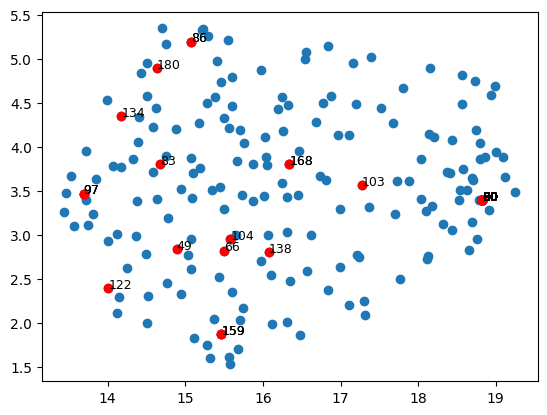

In [235]:
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1])
for item in outputs['targets'][1][0]:
    # highlight in red
    plt.scatter(data[item,0], data[item,1], c='r')
    # add text
    plt.text(data[item,0], data[item,1], str(item.item()), fontsize=9)

plt.show()

In [10]:
tokenizer = tools.load_tokenizer('../lm/tokenizers/tokenizer_spe_bpe_v29/tokenizer.model')

In [88]:
x = tokenizer.text_to_ids("""so today I went to the park""".lower())
x = torch.tensor(x).unsqueeze(0)
length = torch.tensor([len(x[0])])
cache = None
outputs = tlm(x, length, calc_loss=True)#,cache=cache, calc_loss=False)

In [71]:
outputs['targets']

[tensor([[ 1, 16, 15,  1,  7,  4, 16,  2,  1, 25,  2, 19, 19]]),
 tensor([[ 43,  23, 112,  97,  61, 172, 158]]),
 tensor([[ 2, 81,  6, 47]]),
 tensor([[1, 2]])]

In [72]:
tlm.layers.layers[0][-1].fn.codebook.shape

torch.Size([186, 64])

In [58]:
z=  list(set(dta))
import random
# random selection
random.shuffle(z)
z = z[:100]
z

[31,
 21,
 67,
 128,
 25,
 41,
 120,
 135,
 48,
 83,
 78,
 118,
 90,
 70,
 140,
 162,
 165,
 167,
 79,
 148,
 51,
 13,
 71,
 4,
 2,
 29,
 24,
 77,
 98,
 64,
 55,
 5,
 63,
 179,
 54,
 43,
 123,
 7,
 175,
 8,
 155,
 147,
 138,
 130,
 169,
 161,
 108,
 181,
 52,
 32,
 14,
 47,
 36,
 34,
 1,
 74,
 16,
 81,
 178,
 62,
 30,
 172,
 157,
 145,
 75,
 20,
 59,
 146,
 42,
 6,
 68,
 106,
 127,
 134,
 82,
 61,
 80,
 126,
 160,
 93,
 105,
 115,
 144,
 10,
 143,
 69,
 137,
 37,
 103,
 46,
 121,
 164,
 109,
 57,
 3,
 129,
 174,
 154,
 163,
 116]

In [255]:
z = tlm.layers.layers[1][-1].fn.codebook[0]
z = tlm.layers.layers[1][-1].fn.project_out(z)
z,_= tlm.layers.halfer.inverse_halfer(z[None,None,:],length=torch.tensor([1]))
z,_ = tlm.layers.halfer.halfer(z,length=torch.tensor([1,1]))
z.shape

torch.Size([1, 1, 512])

In [243]:
dta = {}
import random
for idx in range(186):
    entry = tlm.layers.layers[0][-1].fn.codebook[idx]
    entry = tlm.layers.layers[0][-1].fn.project_out(entry)
    #print(entry.shape)
    entry,_ = tlm.layers.halfer.inverse_halfer(entry[None,None,:], length=torch.tensor([1]))
    #print(entry.shape)
    
    pred = tlm.layers.layers[0][4](entry)

    pred = pred.softmax(dim=-1).argmax(dim=-1).squeeze().tolist()
    #print(pred)
    dta[idx] = tokenizer.ids_to_text(pred)
dta

[4, 22]
[2, 12]
[21, 15]
[19, 12]
[19, 9]
[3, 15]
[12, 3]
[4, 3]
[19, 2]
[3, 1]
[21, 12]
[4, 3]
[18, 13]
[4, 22]
[3, 8]
[18, 9]
[2, 1]
[3, 3]
[4, 3]
[4, 23]
[19, 12]
[1, 7]
[19, 12]
[3, 15]
[18, 22]
[12, 3]
[12, 22]
[3, 0]
[18, 7]
[12, 22]
[21, 10]
[12, 12]
[18, 9]
[3, 9]
[4, 15]
[7, 9]
[3, 22]
[21, 9]
[1, 5]
[3, 15]
[14, 10]
[21, 11]
[4, 3]
[1, 22]
[24, 17]
[7, 7]
[12, 12]
[4, 3]
[19, 22]
[3, 9]
[3, 18]


{0: 'ph',
 1: 'on',
 2: 'dh',
 3: 'gt',
 4: 'fe',
 5: 'at',
 6: 'fr',
 7: 'dd',
 8: 'nn',
 9: 'at',
 10: 'tt',
 11: 'gv',
 12: 'av',
 13: 'd',
 14: 'gl',
 15: 'bh',
 16: 'eh',
 17: 'dv',
 18: 'nn',
 19: 'gv',
 20: 'at',
 21: 'dv',
 22: 'dn',
 23: 'on',
 24: 'fl',
 25: 'gx',
 26: 'av',
 27: 'td',
 28: 'fh',
 29: 'd',
 30: 'lv',
 31: 'av',
 32: 'th',
 33: 'av',
 34: 'nw',
 35: 'fv',
 36: 'fh',
 37: 'te',
 38: 'dh',
 39: 'av',
 40: 'tr',
 41: 'th',
 42: 'be',
 43: 'dt',
 44: 'dt',
 45: 'oe',
 46: 'av',
 47: 'th',
 48: 'et',
 49: "'d",
 50: 'dd',
 51: 'nv',
 52: 'oh',
 53: 'ge',
 54: '',
 55: 'gr',
 56: 'bt',
 57: "'y",
 58: 'gh',
 59: 'f ⁇',
 60: 'ox',
 61: 'dh',
 62: 'f',
 63: 'fv',
 64: 'dl',
 65: 'on',
 66: 'h',
 67: 'gv',
 68: 'th',
 69: 'ga',
 70: 'at',
 71: 'dv',
 72: 'o',
 73: 'at',
 74: 'fv',
 75: 'oy',
 76: 'bv',
 77: 'tv',
 78: 'ol',
 79: 'b',
 80: 'av',
 81: 'al',
 82: 'tr',
 83: 'tn',
 84: 'e',
 85: 'eh',
 86: 'dd',
 87: "'",
 88: 'dl',
 89: 'ge',
 90: 'dv',
 91: 'fe',
 92: 't

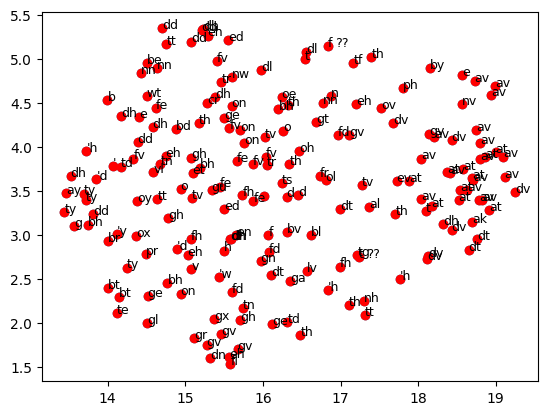

In [237]:
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1])
for item in range(data.shape[0]):
    # highlight in red
    plt.scatter(data[item,0], data[item,1]  , c='r')
    # add text
    plt.text(data[item,0], data[item,1], dta[item], fontsize=9)
'''for item in outputs['targets'][1][0]:
    # highlight in red
    plt.scatter(data[item,0], data[item,1], c='r')
    # add text
    plt.text(data[item,0], data[item,1], dta[item.item()], fontsize=9)
'''
plt.show()

In [ ]:
tlm.layers.layers[1][-1]

In [137]:
tlm.layers.layers[1][5]

PredictionLayer(
  (proj): PreNorm(
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (fn): Linear(in_features=256, out_features=29, bias=True)
  )
)

In [93]:
outputs['token_losses']

tensor([ 5.1571, 12.0813, 12.6801,  6.1763], grad_fn=<AddBackward0>)

In [240]:
a = outputs['logits'][0][0].softmax(-1).argmax(-1).tolist()
a
tokenizer.ids_to_text(a)

'aomtelvteon tfenation  and temh r tf er tovrol tow o k  aoom the saosoect oe tf tynerseaoap taavn ng tontider ng temh r tn er tomrecynion  aefween to n  aaststn rte th t cewrou tn tuite taass n l'

In [239]:
"""Convolution operations and higher order neural networks From the perspective of modern
deep learning considering higher order correlations between downstream inputs to a neuron is
quite classical"""

'Convolution operations and higher order neural networks From the perspective of modern\ndeep learning considering higher order correlations between downstream inputs to a neuron is\nquite classical'

In [413]:
outputs['targets']

[tensor([[ 1, 17,  9,  4,  3,  1,  3,  6, 16,  2,  1,  6,  8,  1,  6,  3,  1,  5,
           9,  1,  7,  5,  1, 21, 11,  4,  9,  1, 21, 11,  4,  9,  1, 27, 27,  1,
           6,  1, 11,  6, 23,  2,  1, 14,  4, 10, 10,  5,  3,  8]]),
 tensor([[ 30,  37, 124,  45, 119, 118, 105,  95,  62,   7,  99, 160, 137,   7,
            0, 100,  62, 110, 124,  74, 119, 134,  89,  99, 182]]),
 tensor([[260, 254,  35, 254, 314, 384,  35, 254,  27, 254,  35, 172, 390]]),
 tensor([[357, 140, 140, 140, 140, 140, 689]])]

In [94]:
labels = torch.randint(0, 29, (3, 25))
length = torch.tensor([6, 1, 25])
tlm_out = tlm(labels, length, calc_loss=True, cache=tlm_out['cache'])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_2637/3567845408.py:3 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2637/3567845408.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'tlm_out' is not defined

In [424]:
tlm_out['targets']

[tensor([[ 3,  4, 13, 15, 21, 10, 17, 25, 14, 20, 16,  3,  7, 19,  3,  8,  7, 13,
          24,  6, 10, 25, 22,  4, 24],
         [26,  2, 19,  6, 10,  9, 27, 21, 24,  3, 21, 23, 13, 27, 13, 19, 12,  4,
          18, 16, 21, 25, 14, 25, 10],
         [14,  1, 20, 15, 28, 26, 28, 23, 23, 28, 19,  7, 23,  9,  4, 10, 22, 24,
          25, 21, 16, 22, 27, 28, 16]]),
 tensor([[137,  89,   0, 102, 152,  95, 145, 182, 146,  45, 174,  11, 164],
         [119, 117, 100, 119,  95,   0, 169, 168, 106,  61,   0, 152, 174],
         [  7, 104, 169, 152, 163,  56, 100,  89, 163,  22,   8, 134,  43]]),
 tensor([[448, 228,  96,  50, 139, 461, 391],
         [156, 461, 448, 301, 156, 448, 390],
         [156,  50, 466, 448, 138,  48, 391]]),
 tensor([[427, 309, 426, 494],
         [494,  96, 426, 742],
         [665, 328, 328, 494]])]

In [191]:
torch.cat([torch.tensor([0.]),tlm_out['token_losses']])

tensor([ 0.0000,  3.3361,  9.0943, 11.7116, 12.9673], grad_fn=<CatBackward0>)

In [132]:
tlm_out['cache'][0]['layer_below_next_sentence_pred'].shape

torch.Size([3, 2, 29])

In [138]:
[el.shape for el in tlm_out['layer_below_predictions'] if el is not None]

[torch.Size([3, 10, 29]), torch.Size([3, 5, 186]), torch.Size([3, 3, 471])]

tensor([[[ 0.5522,  0.7073, -0.4004, -1.7506, -0.3139, -0.3931, -0.5387,
          -0.3880,  0.9586, -0.7569,  0.3536, -0.6996, -0.7060,  1.7352,
          -1.5477,  1.5172,  1.1682,  0.7225,  0.0731,  2.8862, -0.4295,
           0.3552,  0.9085, -0.1108, -0.2837, -0.1412,  0.2152, -0.3472,
           3.5744]],

        [[-0.8612, -0.3983,  0.2439, -0.0434, -0.0573,  0.2012,  0.0373,
           0.5064, -1.8880, -1.3106, -0.3143, -0.5900, -1.3373, -0.6801,
          -1.1815, -1.3725, -0.5302,  0.2932,  1.1263, -2.9227, -1.2165,
          -0.3096,  0.0746,  2.1863, -0.7000, -2.6588,  0.9164,  0.5734,
          -0.8377]],

        [[-0.5840,  1.0222, -0.4094,  1.4468,  0.3316,  0.2704, -0.3063,
           0.6731,  0.0478,  1.6772,  0.4766,  0.7292, -1.9728, -0.5385,
           0.5501, -0.0900, -0.6048,  0.3224, -0.5616, -1.0638,  0.7505,
          -0.3843,  0.1069,  0.4991,  1.2616,  0.1580, -0.1634,  0.4385,
           1.0510]]], grad_fn=<SliceBackward0>)

In [119]:
idx = torch.stack([length-2,length-1], dim=1)[...,None].expand(-1,-1,29)

In [121]:
x.gather(dim=1, index=idx).shape

torch.Size([3, 2, 29])